<a href="https://colab.research.google.com/github/bindhujk/web_mining_project/blob/main/Web_mining_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095448 sha256=75c867916aeaf96bbd16c846fb935241f8c22bb1fe31a3f6e6b9c7daba495d5f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import csv
import pandas as pd
import re
import numpy as np
from sklearn import preprocessing
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from pdb import set_trace
from surprise.accuracy import mse, rmse, mae
from surprise import Dataset, Reader, KNNBasic
import seaborn as sns

In [ ]:
import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def make_csv_file(srcfile, targetfile):
    with open(srcfile, 'r') as dat_file:
        with open(targetfile, 'w', newline='', encoding = 'utf-8') as csv_file:
            csv_writer = csv.writer(csv_file)
            for row in dat_file:
                row = [value.strip() for value in row.split('::')]
                csv_writer.writerow(row)

In [ ]:
df_ratings = pd.read_csv('/content/gdrive/MyDrive/ratings.csv')
df_movies = pd.read_csv('/content/gdrive/MyDrive/movies.csv')
df_users = pd.read_csv('/content/gdrive/MyDrive/users.csv')

In [ ]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


df_ratings['Rating'].mean()

In [ ]:
df_movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
df_users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [ ]:
df_users.loc[df_users['Occupation']==0]

,UserID,Gender,Age,Occupation,Zip-code
13,14,M,35,0,60126
15,16,F,35,0,20670
22,23,M,35,0,90049
31,32,F,25,0,19355
33,34,F,18,0,02135
...,...,...,...,...,...
6009,6010,M,35,0,79606
6018,6019,M,25,0,10024
6022,6023,M,25,0,43213
6030,6031,F,18,0,45123


## **Exploratory data analysis**

In [ ]:
df_ratings.isna().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [ ]:
df_movies.isna().sum()

MovieID    0
Title      0
Genres     0
dtype: int64

In [ ]:
df_users.isna().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [ ]:
df_ratings['Rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

<Axes: xlabel='Rating', ylabel='Count'>

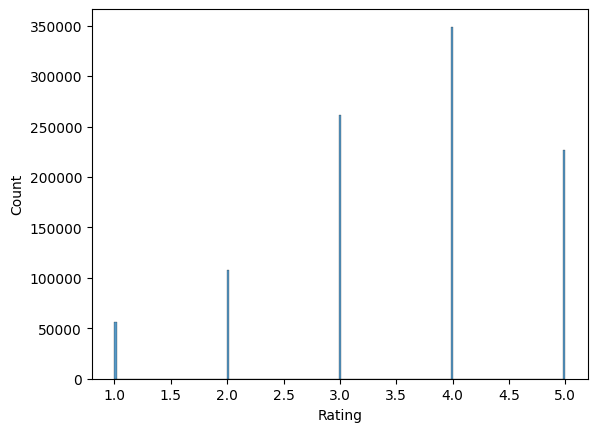

In [ ]:
sns.histplot(df_ratings['Rating'])

## **Data Preprocessing**

Remove features that are not necessary

In [ ]:
df_ratings.drop('Timestamp', axis=1, inplace=True)

Preprocessing 'Title' and 'Genre' column of df_movies dataset

In [ ]:
def year(x):
  x = re.findall('\d{4}', x)
  return x[0]

In [ ]:
df_movies['Year'] = df_movies['Title'].apply(year)

In [ ]:
def title(x):
  x = re.sub('(\d{4})', '', x)
  x = re.sub('\([^)]*\)', '', x)
  x = re.sub('[^a-zA-Z]+', ' ', x)
  x = re.sub("'", '', x)
  x = re.sub(r'\\s+', ' ', x)
  return x

In [ ]:
df_movies['Title'] = df_movies['Title'].apply(title)
df_movies['Genres'] = df_movies['Genres'].apply(title)

In [ ]:
df_movies

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation Children s Comedy,1995
1,2,Jumanji,Adventure Children s Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995
3,4,Waiting to Exhale,Comedy Drama,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000
3879,3949,Requiem for a Dream,Drama,2000
3880,3950,Tigerland,Drama,2000
3881,3951,Two Family House,Drama,2000


Preprocessing 'Gender' and 'Occupation' column of df_users dataset

In [ ]:
df_users['Gender'] = df_users['Gender'].replace({'M': 'Male', 'F': 'Female'})

In [ ]:
categories = ["other","academic/educator","artist","clerical/admin","college/grad student","customer service","doctor/health care",
              "executive/managerial","farmer","homemaker","K-12 student","lawyer","programmer","retired","sales/marketing","scientist",
              "self-employed","technician/engineer","tradesman/craftsman","unemployed","writer"]

In [ ]:
df_users['Occupation'] = pd.Categorical.from_codes(df_users['Occupation'], categories)

In [ ]:
import re

def pre(x):
  x = re.sub('[^a-zA-Z]+', ' ', x)
  x = re.sub("'", '', x)
  x = re.sub(r'\\s+', ' ', x)
  return x
df_users['Occupation'] = df_users['Occupation'].apply(pre)

In [ ]:
df_users

,UserID,Gender,Age,Occupation,Zip-code
0,1,Female,1,K student,48067
1,2,Male,56,self employed,70072
2,3,Male,25,scientist,55117
3,4,Male,45,executive managerial,02460
4,5,Male,25,writer,55455
...,...,...,...,...,...
6035,6036,Female,25,scientist,32603
6036,6037,Female,45,academic educator,76006
6037,6038,Female,56,academic educator,14706
6038,6039,Female,45,other,01060


### Functions for evaluation metrics

In [ ]:
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def precision_recall_f1(predictions, threshold=3.5):
    """Return precision, recall and f1 metrics averaged across all users"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    # collect metrics per user
    precisions = dict()
    recalls = dict()
    f1s = dict()
    accuracies = dict()
    
    for uid, user_ratings in user_est_true.items():
        
        # get relevance labels for average precision calculation
        y_true = [1 if (true_r >= threshold) else 0 for (_, true_r) in user_ratings]
        y_pred = [1 if (est_r >= threshold) else 0 for (est_r, _) in user_ratings]
        
        precisions[uid] = precision_score(y_true, y_pred, zero_division=0)
        recalls[uid] = recall_score(y_true, y_pred, zero_division=0)
        f1s[uid] = f1_score(y_true, y_pred, zero_division=0)

        accuracies[uid] = accuracy_score(y_true, y_pred)

    # average scores over all users 
    avg_precision = sum(list(precisions.values())) / len(list(precisions.values()))
    avg_recall = sum(list(recalls.values())) / len(list(recalls.values()))
    avg_f1 = sum(list(f1s.values())) / len(list(f1s.values()))
    
    avg_accuracy = sum(list(accuracies.values())) / len(list(accuracies.values()))
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy

In [ ]:
from sklearn.metrics import average_precision_score, ndcg_score

def measures_at_k(predictions, k=10, threshold=3.5):
    """Return precision and nDCG at k metrics averaged across all users"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    average_precisions = dict()
    precisions_at_k = dict()
    ndcgs_at_k = dict()

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # get relevance labels for average precision calculation
        y_true = [1 if (true_r > threshold) else 0 for (_, true_r) in user_ratings]
        y_pred = [1 if (est_r > threshold) else 0 for (est_r, _) in user_ratings]
        
        y_true_at_k = y_true[:k]
        y_pred_at_k = y_pred[:k]
        
        if sum(y_true) > 0:
            average_precisions[uid] = average_precision_score(y_true, y_pred)
        else:
            average_precisions[uid] = 0

        precisions_at_k[uid] = precision_score(y_true_at_k, y_pred_at_k, zero_division=0)
        
        if not len(user_ratings) == 1:
            ndcgs_at_k[uid] = ndcg_score(np.asarray([[x for (_, x) in user_ratings]]), np.asarray([[x for (x, _) in user_ratings]]), k=k)
        elif len(user_ratings) == 1:
            ndcgs_at_k[uid] = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings
        )
            
        # compute simple averages over all users for each score:
        avg_average_precisions = sum(val for val in average_precisions.values()) / len(average_precisions)
        avg_precisions_at_k = sum(val for val in precisions_at_k.values()) / len(precisions_at_k)
        avg_ndcgs_at_k = sum(val for val in ndcgs_at_k.values()) / len(ndcgs_at_k)

    return avg_average_precisions, avg_precisions_at_k, avg_ndcgs_at_k

### Function to generate example recommendations for a user

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

## **Collaborative Filtering**

In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_ratings[['UserID','MovieID','Rating']], reader)

### **Baseline models**

### 1. KNNBasic

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=my_seed)

In [ ]:
sim_options = {'name': 'pearson', 'user_based': True, 'min_support': 1}

algo = KNNBasic(sim_options=sim_options)

algo.fit(trainset)
predictions_knn = algo.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
mse(predictions_knn)
rmse(predictions_knn)
mae(predictions_knn);

MSE: 0.9311
RMSE: 0.9649
MAE:  0.7675


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_knn, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.7258184888990705
Avg. Recall: 0.7876402587966836
Avg. F1: 0.7347869431098045
Avg. Accuracy: 0.6957136354098599


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_knn, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.7071502544247958
Avg. Precision@5: 0.8107064017660277
Avg. nDCG@5: 0.8881175990438974


### 2. SVD

In [ ]:
from surprise import SVD

algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions_svd = algo.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions_svd)
rmse(predictions_svd)
mae(predictions_svd);

MSE: 0.8652
RMSE: 0.9302
MAE:  0.7443


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_svd, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.721988837137242
Avg. Recall: 0.7830978703273676
Avg. F1: 0.7292526567024816
Avg. Accuracy: 0.7233741968917056


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_svd, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.6949520240187177
Avg. Precision@5: 0.8051324503311484
Avg. nDCG@5: 0.8882310127727668


### **Hyperparameter tuning**

In [ ]:
!pip install auto_surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import Dataset
from surprise import Reader
from auto_surprise.engine import Engine
import pandas as pd


# Create a reader object with the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset from the dataframe
data = Dataset.load_from_df(df_ratings[['UserID', 'MovieID', 'Rating']], reader)

# Intitialize auto surprise engine
engine = Engine(verbose=True)

# Start the trainer
best_algo, best_params, best_score, tasks = engine.train(
    data=data,
    target_metric='test_rmse', # The metric we seek to minimize
    cpu_time_limit=60 * 60, # The time limit we want to train in seconds
    max_evals=100 # The maximum number of evaluations each algorithm gets for hyper parameter optimization
)

# Print the results
print(f"Best algorithm: {best_algo}")
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

# Build a pickelable model with the best algorithm and parameters
model = engine.build_model(best_algo, best_params)

auto_surprise 0.1.8

Available CPUs: 2

INFO:auto_surprise.context.result_logging_manager_normal_predictor:Started hyperarameter optimization
INFO:auto_surprise.context.result_logging_manager_normal_predictor:Execution time: 0:00:45 Loss: 1.5068472273865778 Hyperparameters: None


Evaluating RMSE, MAE, MSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5082  1.5056  1.5034  1.5093  1.5077  1.5068  0.0021  
MAE (testset)     1.2086  1.2063  1.2053  1.2101  1.2096  1.2080  0.0019  
MSE (testset)     2.2745  2.2667  2.2603  2.2780  2.2733  2.2706  0.0063  
Fit time          2.83    5.56    1.65    1.63    1.67    2.67    1.51    
Test time         4.49    3.53    3.31    1.23    2.35    2.98    1.11    


INFO:auto_surprise.context.result_logging_manager_normal_predictor:Done!


Baseline loss: 1.5068472273865778

Starting process with svd algorithm
Starting process with svdpp algorithm


INFO:auto_surprise.context.result_logging_manager_svd:Started hyperarameter optimization


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]Starting process with nmf algorithm


INFO:auto_surprise.context.result_logging_manager_svdpp:Started hyperarameter optimization


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]Starting process with knn_basic algorithm



INFO:auto_surprise.context.result_logging_manager_nmf:Started hyperarameter optimization


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Exception for algo svd


Starting process with knn_baseline algorithm


ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


INFO:auto_surprise.context.result_logging_manager_knn_basic:Started hyperarameter optimization


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:auto_surprise.context.result_logging_manager_svd:Done!
ERROR:auto_surprise.trainer:Exception for algo svdpp


Starting process with knn_with_means algorithm


ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


INFO:auto_surprise.context.result_logging_manager_svdpp:Done!


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Exception for algo nmf
INFO:auto_surprise.context.result_logging_manager_knn_baseline:Started hyperarameter optimization


Starting process with knn_with_z_score algorithm


ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:auto_surprise.context.result_logging_manager_knn_with_means:Started hyperarameter optimization
INFO:auto_surprise.context.result_logging_manager_nmf:Done!
ERROR:auto_surprise.trainer:Exception for algo knn_basic


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)

ERROR:auto_surprise.trainer:Exception for algo knn_baseline
INFO:auto_surprise.context.result_logging_manager_knn_basic:Done!
INFO:auto_surprise.context.result_logging_manager_knn_with_z_score:Started hyperarameter optimization


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)

Starting process with slope_one algorithm
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


INFO:auto_surprise.context.result_logging_manager_co_clustering:Started hyperarameter optimization


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Exception for algo knn_with_means
INFO:auto_surprise.context.result_logging_manager_knn_baseline:Done!
ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/l

Starting process with baseline_only algorithm
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


INFO:auto_surprise.context.result_logging_manager_slope_one:Started hyperarameter optimization
INFO:auto_surprise.context.result_logging_manager_knn_with_means:Done!


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Exception for algo knn_with_z_score


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)

ERROR:auto_surprise.trainer:Exception for algo co_clustering
ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    ne

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


ERROR:auto_surprise.trainer:Exception for algo baseline_only
ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    ne

Evaluating RMSE, MAE, MSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9069  0.9061  0.9056  0.9046  0.9099  0.9066  0.0018  
MAE (testset)     0.7147  0.7140  0.7138  0.7132  0.7169  0.7145  0.0013  
MSE (testset)     0.8225  0.8210  0.8202  0.8182  0.8278  0.8220  0.0033  
Fit time          12.77   13.17   13.35   13.01   13.42   13.14   0.23    
Test time         58.88   58.42   57.42   58.54   58.13   58.28   0.49    


INFO:auto_surprise.context.result_logging_manager_slope_one:Execution time: 0:06:08 Loss: 0.9066190344071057 Hyperparameters: None
INFO:auto_surprise.context.result_logging_manager_slope_one:Done!


----Done!----

Best algorithm: slope_one

Best hyperparameters: None

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Algorithm        ┃ Hyperparameters ┃               Loss ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ svd              │ None            │               None │
│ svdpp            │ None            │               None │
│ nmf              │ None            │               None │
│ knn_basic        │ None            │               None │
│ knn_baseline     │ None            │               None │
│ knn_with_means   │ None            │               None │
│ knn_with_z_score │ None            │               None │
│ co_clustering    │ None            │               None │
│ baseline_only    │ None            │               None │
│ slope_one        │ None            │ 0.9066190344071057 │
└──────────────────┴─────────────────┴────────────────────┘

Best algorithm: slope_one
Best parameters: None
Best score: 0.9066190344071057


In [ ]:
model.fit(trainset)
predictions_best = model.test(testset)

In [ ]:
mse(predictions_best)
rmse(predictions_best)
mae(predictions_best);

MSE: 0.8251
RMSE: 0.9083
MAE:  0.7154


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_best, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.731266642206662
Avg. Recall: 0.7599667426450937
Avg. F1: 0.7261660397139151
Avg. Accuracy: 0.7240046114700436


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_best, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.7040238963226542
Avg. Precision@5: 0.8077262693156962
Avg. nDCG@5: 0.8897121898186425


### Getting some predictions

In [ ]:
top_n = get_top_n(predictions_best, n=5)

# Let's get recommendations for user 196
uid = 256
# collect all movies the user rated
user_movies = df_ratings[df_ratings['UserID'] == int(uid)]

# get the recommendations for the specific user from the top_n dict
recommendations = [df_movies[df_movies['MovieID'] == int(iid)]['Title'].iloc[0] for (iid, _) in top_n[uid]]

print('Top 5 recommendations for user with id 196:')
for i, rec in enumerate(recommendations):
    print(f'{i+1} {rec}')

Top 5 recommendations for user with id 196:
1 Big Sleep The 
2 Chinatown 
3 Star Wars Episode V The Empire Strikes Back 
4 Saving Private Ryan 
5 Matrix The 


In [ ]:
# First we collect all movies the user rated and filter them down to only those appearing in the test set
user_movies = df_ratings[df_ratings['UserID'] == uid].sort_values(by='Rating', ascending=False)
movies_relevant = []
for user, movie, rating in testset:
    if user == uid:
        movies_relevant.append(df_movies[df_movies['MovieID'] == int(movie)]['Title'].iloc[0])

for movie in movies_relevant:
    print(movie)

Usual Suspects The 
L A Confidential 
Sixth Sense The 
What Ever Happened to Baby Jane 
Almost Famous 
Meet the Parents 
Godfather Part II The 
Four Weddings and a Funeral 
American Beauty 
High Fidelity 
Rear Window 


## **Content-based recommender**

In [ ]:
import pandas as pd
# assuming movies and ratings are already defined as dataframes
df_merged = pd.merge(df_movies, df_ratings, on='MovieID', how='inner')
df_merged = pd.merge(df_merged, df_users, on='UserID', how='inner')

In [ ]:
df_merged

,MovieID,Title,Genres,Year,UserID,Rating,Gender,Age,Occupation,Zip-code
0,1,Toy Story,Animation Children s Comedy,1995,1,5,Female,1,K student,48067
1,48,Pocahontas,Animation Children s Musical Romance,1995,1,5,Female,1,K student,48067
2,150,Apollo,Drama,1995,1,5,Female,1,K student,48067
3,260,Star Wars Episode IV A New Hope,Action Adventure Fantasy Sci Fi,1977,1,4,Female,1,K student,48067
4,527,Schindler s List,Drama War,1993,1,5,Female,1,K student,48067
...,...,...,...,...,...,...,...,...,...,...
1000204,3513,Rules of Engagement,Drama Thriller,2000,5727,4,Male,25,college grad student,92843
1000205,3535,American Psycho,Comedy Horror Thriller,2000,5727,2,Male,25,college grad student,92843
1000206,3536,Keeping the Faith,Comedy Romance,2000,5727,5,Male,25,college grad student,92843
1000207,3555,U,Action Thriller,2000,5727,3,Male,25,college grad student,92843


In [ ]:
type(df_merged['Occupation'][0])

str

In [ ]:
from gensim.utils import tokenize
# Prepare Content
df_merged['content'] = df_merged['Title'] + ' ' + df_merged['Genres'].astype(str)+ ' ' + df_merged['Gender'].astype(str) + ' ' + df_merged['Occupation'].astype(str)
merged_content_dict = dict(zip(df_merged['MovieID'], df_merged['content']))

# Add content to trainset to parse the content of the movies to the trainset
#Convert content to list - Make sure that starting from 0 to the highest movieId a content entry exists in the list
trainset.content = [merged_content_dict[key] if key in merged_content_dict else '' for key in range(0, max(merged_content_dict.keys()))]

In [ ]:
reader = Reader(rating_scale=(1, 5))

df_merged = Dataset.load_from_df(df_ratings, reader)
df_merged.content = [merged_content_dict[key] if key in merged_content_dict else '' for key in range(0, max(merged_content_dict.keys()))]

In [ ]:
# Import KNNBasic from surprise
# Content-based Prediction using the Gensim library
from surprise import AlgoBase, Dataset, PredictionImpossible
from surprise.model_selection import cross_validate
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.similarities import SparseMatrixSimilarity

sim_options = {'name': 'cosine', 'user_based': True}

# Define a custom content-based recommender class that inherits from KNNBasic
class ContentKNN(KNNBasic):
    def __init__(self,k=5, sim_options=sim_options):
        # Call the base method and pass the sim_options parameter
        KNNBasic.__init__(self, sim_options=sim_options)
        self.k=k
        self.df = df_merged
    
    def fit(self, trainset):
        # Call the base method before doing anything
        KNNBasic.fit(self, trainset)
        
        # Tokenize content by whitespace
        tokenized_content = [list(tokenize(line)) for line in df_merged.content]
        
        # Compute TF-IDF Similarity Matrix
        dct = Dictionary(tokenized_content) # fit dictionary
        self.corpus = [dct.doc2bow(line) for line in tokenized_content]
        self.model = TfidfModel(self.corpus)

        
        # Prepare Index
        self.index = SparseMatrixSimilarity(self.model[self.corpus], num_features=len(dct))

        return self
    
    
    def estimate(self, u, i):
        
        # The user must be "known" as we need at least 1 rated item to make a recommendation
        if self.trainset.knows_user(u):
            # Get user ratings
            user_ratings = self.trainset.ur[u]
            
            # if an item is not "known" to the training set (cold-start) we still can
            # make a prediction with the content-based recommender
            if type(i) is str:
                i = int(i.replace('UKN__', '')) - 1
            
            # Get similarities
            try:
                similarities = self.index[self.corpus[i]]
            except TypeError:
                set_trace()
            
            # Filter user similarity scores by number of nearst neighbours and threshold > 0
            sim_user_dict = {user_rating[0]: similarities[user_rating[0]] for user_rating in user_ratings}
            sorted_filtered_sim = sorted(list(sim_user_dict.values()), reverse=True)[0:self.k]
            sim_user_dict = {user: sim for user, sim in sim_user_dict.items() if sim > 0 and sim in sorted_filtered_sim}
            
            #Simple prediction
            if len(sim_user_dict) > 0:
                rating = sum([sim_user_dict[user_rating[0]]*user_rating[1] for user_rating in user_ratings if user_rating[0] in sim_user_dict])/\
                sum([sim_user_dict[user_rating[0]] for user_rating in user_ratings if user_rating[0] in sim_user_dict])
            else:
                raise PredictionImpossible("No similar items found.")
        else:
            raise PredictionImpossible("User is unknown.")
        
        
        return rating

In [ ]:
knn = ContentKNN(k=5)

# Train the algorithm on the trainset, and predict ratings for the testset
knn.fit(trainset)
predictions_contentknn = knn.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions_contentknn)
rmse(predictions_contentknn)
mae(predictions_contentknn);

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 1.2804
RMSE: 1.1315
MAE:  0.9003


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_contentknn, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.6179173871941218
Avg. Recall: 0.6813181885138346
Avg. F1: 0.6323690951875801
Avg. Accuracy: 0.6152680544142562


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_contentknn, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.6326059459895277
Avg. Precision@5: 0.624379139072854
Avg. nDCG@5: 0.7831808252694338


### Hyperparameter tuning

In [ ]:
# Import GridSearchCV from surprise
from surprise.model_selection import GridSearchCV

# Define a dictionary of hyperparameters and their values to search over
param_grid = {
    'k': [3, 5, 10, 20],
    'sim_options': {
        'name': ['cosine'],
        'user_based': [True]
    }
}

# Create a GridSearchCV object with the content-based recommender and the parameter grid
grid_search = GridSearchCV(ContentKNN, param_grid, cv=5)

# Fit the grid search on the Trainset object
grid_search.fit(df_merged)

# Print the best score and the best parameters
print("Best score: {}".format(grid_search.best_score))
print("Best parameters: {}".format(grid_search.best_params))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [ ]:
knn = ContentKNN(k=20)

# Train the algorithm on the trainset, and predict ratings for the testset
knn.fit(trainset)
predictions_contentknn_best = knn.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions_contentknn_best)
rmse(predictions_contentknn_best)
mae(predictions_contentknn_best);

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 1.1377
RMSE: 1.0666
MAE:  0.8534


In [ ]:
predictions_contentknn_best

In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_contentknn_best, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.6179173871941218
Avg. Recall: 0.6813181885138346
Avg. F1: 0.6323690951875801
Avg. Accuracy: 0.6152680544142562


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_contentknn_best, k=20, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.631121248246841
Avg. Precision@5: 0.6139292399649627
Avg. nDCG@5: 0.8505759662823443


In [ ]:
top_n = get_top_n(predictions_contentknn, n=5)

# collect all movies the user rated
user_movies = df_ratings[df_ratings['UserID'] == int(uid)]

# get the recommendations for the specific user from the top_n dict
recommendations = [df_movies[df_movies['MovieID'] == int(iid)]['Title'].iloc[0] for (iid, _) in top_n[uid]]

print('Top 5 recommendations for user with id 256:')
for i, rec in enumerate(recommendations):
    print(f'{i+1} {rec}')

Top 5 recommendations for user with id 256:
1 Saving Private Ryan 
2 Pope of Greenwich Village The 
3 Snake Eyes 
4 Big Sleep The 
5 Chinatown 


In [ ]:
# First we collect all movies the user rated and filter them down to only those appearing in the test set
user_movies = df_ratings[df_ratings['UserID'] == uid].sort_values(by='Rating', ascending=False)
movies_relevant = []
for user, movie, rating in testset:
    if user == uid:
        movies_relevant.append(df_movies[df_movies['MovieID'] == int(movie)]['Genres'].iloc[0])

for movie in movies_relevant:
    print(movie)

Action Adventure Fantasy
Action Adventure Fantasy Sci Fi
Action Thriller
Action Adventure Sci Fi Thriller
Action
Drama Thriller
Action Adventure Romance Thriller
Film Noir Mystery
Action Sci Fi Thriller
Action Crime Mystery Thriller
Action Drama War
Film Noir Mystery Thriller
Action Thriller
Action
Action Adventure
Action Drama War
Action Adventure Fantasy Sci Fi
Action Romance
Action Romance War
Action Adventure Sci Fi
Action Adventure Romance Sci Fi War
Action Thriller
Crime Drama Film Noir Thriller
Action Adventure Drama Sci Fi War
Action Comedy Crime Drama


### **Hybrid recommender system**

In [ ]:
from surprise.prediction_algorithms import SlopeOne

In [ ]:
class ContentKNNBasicHybrid(AlgoBase):
    def __init__(self,k=20, name='cosine', user_based=True, min_support=1):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)
        self.k = k
        self.name = name
        self.user_based = user_based
        self.min_support = min_support
    
    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)
        
        self.content = ContentKNN(k=20)
        self.content.fit(trainset)
        
        sim_options = {'name': self.name, 'user_based': self.user_based, 'min_support': self.min_support}
        self.slopeone = SlopeOne()
        self.slopeone.fit(trainset)

        return self
    
    
    def estimate(self, u, i):
        # Implement estimation

        if self.trainset.knows_user(u):
            r_content = self.content.estimate(u, i)
            r_slopeone = self.slopeone.estimate(u, i)

            #Simple prediction using the average of both ratings
            rating = (r_content + r_slopeone) / 2
        else:
            raise PredictionImpossible("User is unknown.")
            
        return rating

In [ ]:
algo = ContentKNNBasicHybrid(k=20, name='cosine', user_based=True, min_support=1)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)
  
# Then compute MSE, RMSE and MAE
mse(predictions)
rmse(predictions)
mae(predictions);

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 0.9179
RMSE: 0.9581
MAE:  0.7645


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.6775971397688808
Avg. Recall: 0.7685266552074249
Avg. F1: 0.6974352068758655
Avg. Accuracy: 0.7010877064870974


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions, k=20, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.6693452646068477
Avg. Precision@5: 0.7083772230727718
Avg. nDCG@5: 0.9092129140239997


In [ ]:
top_n = get_top_n(predictions, n=5)

# collect all movies the user rated
user_movies = df_ratings[df_ratings['UserID'] == int(uid)]

# get the recommendations for the specific user from the top_n dict
recommendations = [df_movies[df_movies['MovieID'] == int(iid)]['Title'].iloc[0] for (iid, _) in top_n[uid]]

print('Top 5 recommendations for user with id 256:')
for i, rec in enumerate(recommendations):
    print(f'{i+1} {rec}')

Top 5 recommendations for user with id 256:
1 Big Sleep The 
2 Saving Private Ryan 
3 Chinatown 
4 Star Wars Episode V The Empire Strikes Back 
5 Matrix The 
